# California Weather Data Ingestion

**Dataset**: NOAA Climate at a Glance - Statewide Time Series (California)  
**Date Range**: 2000 - 2025 (25 years)  
**Source**: [NOAA Climate at a Glance](https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series)

**Objective**: 
- Load and validate California monthly climate data (2000-2025)
- Verify data quality and temporal coverage
- Understand dataset structure and features
- Document weather conditions during January 2025 fires
- Prepare for comprehensive EDA in Phase 2


## Why Weather Data Matters for Fire Prediction

Weather is the **most dynamic and critical factor** in wildfire ignition and spread. Understanding weather patterns enables prediction of fire risk days or weeks in advance.

### **1. Temperature Effects** 🌡️
- **High temperatures**: Dry out vegetation (fuel moisture decreases)
- **Heat waves**: Multiple consecutive hot days = critically dry fuels
- **Nighttime cooling**: Low TMIN allows some fuel moisture recovery
- **Temperature extremes**: Records broken in January 2025 (unusual winter fires!)
- **Diurnal range**: Large TMAX-TMIN spread indicates low humidity/dry air

### **2. Precipitation (or Lack Thereof)** 💧
- **Rain**: Increases fuel moisture, suppresses fire ignition and spread
- **Dry spells**: Consecutive days without rain = progressive fuel drying
- **Seasonal drought**: California's dry summer (May-October) = peak fire season
- **Precipitation deficit**: Below-normal rainfall = elevated fire risk for months
- **Snow pack**: Affects spring/summer moisture availability

### **3. Fire Weather Patterns** 🌪️
- **Santa Ana winds**: Hot, dry offshore winds = extreme fire danger (100 mph in Jan 2025!)
- **Low humidity**: Dry air pulls moisture from vegetation
- **Wind direction**: Offshore vs. onshore winds affect fire spread
- **Atmospheric stability**: Stable conditions trap heat, unstable brings thunderstorms

### **4. Synoptic Weather Patterns** 🌍
- **High pressure systems**: Block storms, create hot/dry conditions
- **Drought cycles**: Multi-year patterns (El Niño/La Niña)
- **Climate change**: Earlier springs, hotter summers, delayed fall rains
- **Extreme weather events**: Heat domes, atmospheric rivers

### **5. Predictive Power** 🎯
- **Lead time**: Weather forecasts provide 7-30 day advance warning
- **Real-time updates**: Current conditions + forecast = dynamic risk assessment
- **Trigger conditions**: Identify specific weather thresholds (e.g., temp > 35°C + 0 rain for 14 days)
- **Seasonal context**: Same temperature more dangerous in dry season

### **Key Insight for ML:**
The January 2025 Palisades and Eaton fires were fueled by extreme weather: delayed winter rain, record heat, and 100 mph Santa Ana winds. By learning these weather signatures from historical data, our model can predict when similar dangerous conditions emerge—giving communities time to prepare instead of panic.


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


## 1. Load Weather Data


### Dataset Columns Explained

The NOAA Climate at a Glance dataset contains monthly statewide climate data for California:

#### CSV File Structure:
Each CSV file contains 2 columns:
1. **Date**: Month/year (format: YYYYMM, e.g., 200001 = January 2000)
2. **Value**: Monthly measurement value (units depend on file type)

#### Four Separate Files:

| File | Description | Units | Usage in Fire Prediction |
|------|-------------|-------|--------------------------|
| **Average Temperature** | Monthly mean temperature | Fahrenheit (°F) | Overall temperature trends, seasonal patterns |
| **Max Temperature** | Monthly maximum temperature | Fahrenheit (°F) | High temps → dry vegetation, higher fire risk |
| **Min Temperature** | Monthly minimum temperature | Fahrenheit (°F) | Temperature range, nighttime conditions |
| **Precipitation** | Monthly total precipitation | Inches | Rain → wet fuels, lower fire risk |

#### Data Source:
- **Website**: [NOAA Climate at a Glance - Statewide Time Series](https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series)
- **Dataset**: California Statewide Climate Data
- **Documentation**: [Climate at a Glance Documentation](https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/help)
- **Coverage**: 2000-2025 (300+ monthly records per variable)
- **Geographic Scope**: Entire California state (aggregated from all weather stations)


In [2]:
# Load the 4 climate data files
data_dir = Path('../data/raw/weather/')

# File paths
avg_temp_file = data_dir / 'California-Average-Monthly-Temperature-2000-2025.csv'
max_temp_file = data_dir / 'California-Max-Monthly-Temperature-2000-2025.csv'
min_temp_file = data_dir / 'California-Min-Monthly-Temperature-2000-2025.csv'
precip_file = data_dir / 'California-Monthly-Precipitation-2000-2025.csv'

# Load each file (skip first 2 comment lines)
print("Loading California climate data (2000-2025)...")
print("=" * 60)

avg_temp_df = pd.read_csv(avg_temp_file, comment='#')
print(f"✅ Average Temperature: {len(avg_temp_df)} monthly records")

max_temp_df = pd.read_csv(max_temp_file, comment='#')
print(f"✅ Max Temperature: {len(max_temp_df)} monthly records")

min_temp_df = pd.read_csv(min_temp_file, comment='#')
print(f"✅ Min Temperature: {len(min_temp_df)} monthly records")

precip_df = pd.read_csv(precip_file, comment='#')
print(f"✅ Precipitation: {len(precip_df)} monthly records")

print("\n" + "=" * 60)
print(f"Total records loaded: {len(avg_temp_df) + len(max_temp_df) + len(min_temp_df) + len(precip_df):,}")

# Show sample of average temperature data
print("\nSample - Average Temperature Data:")
avg_temp_df.head()


Loading California climate data (2000-2025)...
✅ Average Temperature: 308 monthly records
✅ Max Temperature: 308 monthly records
✅ Min Temperature: 308 monthly records
✅ Precipitation: 308 monthly records

Total records loaded: 1,232

Sample - Average Temperature Data:


,Date,Value
0,200001,45.8
1,200002,47.2
2,200003,50.2
3,200004,57.8
4,200005,63.9


## 2. Dataset Overview


In [3]:
# Combine all datasets into one DataFrame
print("=" * 80)
print("COMBINING CLIMATE DATASETS")
print("=" * 80)

# Rename columns for clarity
avg_temp_df.columns = ['Date', 'Avg_Temp_F']
max_temp_df.columns = ['Date', 'Max_Temp_F']
min_temp_df.columns = ['Date', 'Min_Temp_F']
precip_df.columns = ['Date', 'Precip_Inches']

# Merge all dataframes on Date
climate_df = avg_temp_df.merge(max_temp_df, on='Date', how='outer')
climate_df = climate_df.merge(min_temp_df, on='Date', how='outer')
climate_df = climate_df.merge(precip_df, on='Date', how='outer')

print(f"\n✅ Combined dataset shape: {climate_df.shape}")
print(f"   Rows: {len(climate_df):,} monthly records")
print(f"   Columns: {climate_df.shape[1]}")

# Data types and missing values
print("\n\nData types and missing values:")
info_df = pd.DataFrame({
    'Column': climate_df.columns,
    'Data Type': climate_df.dtypes,
    'Non-Null': climate_df.count(),
    'Null': climate_df.isnull().sum(),
    'Null %': (climate_df.isnull().sum() / len(climate_df) * 100).round(2)
})
print(info_df.to_string(index=False))

print("\n\nFirst 10 rows:")
climate_df.head(10)


COMBINING CLIMATE DATASETS

✅ Combined dataset shape: (308, 5)
   Rows: 308 monthly records
   Columns: 5


Data types and missing values:
       Column Data Type  Non-Null  Null  Null %
         Date     int64       308     0     0.0
   Avg_Temp_F   float64       308     0     0.0
   Max_Temp_F   float64       308     0     0.0
   Min_Temp_F   float64       308     0     0.0
Precip_Inches   float64       308     0     0.0


First 10 rows:


,Date,Avg_Temp_F,Max_Temp_F,Min_Temp_F,Precip_Inches
0,200001,45.8,54.9,36.6,5.09
1,200002,47.2,56.0,38.4,6.93
2,200003,50.2,61.7,38.6,1.92
3,200004,57.8,71.1,44.6,1.80
4,200005,63.9,77.3,50.4,0.94
5,200006,72.2,87.0,57.3,0.31
6,200007,73.5,88.5,58.5,0.06
7,200008,75.0,89.8,60.1,0.27
8,200009,69.1,83.6,54.6,0.35
9,200010,58.4,70.2,46.5,2.20


## 3. Temporal Coverage & Data Quality


TEMPORAL COVERAGE

Date range: January 2000 to August 2025
Total months: 308
Years covered: 26

Missing months: 0


CLIMATE VARIABLE SUMMARY STATISTICS
       Avg_Temp_F  Max_Temp_F  Min_Temp_F  Precip_Inches
count      308.00      308.00      308.00         308.00
mean        59.40       72.04       46.74           1.74
std         11.92       13.79       10.12           2.02
min         40.60       49.20       29.50           0.01
25%         48.35       59.18       37.58           0.26
50%         58.15       70.35       44.65           0.82
75%         71.22       86.20       56.40           2.67
max         81.50       96.80       66.20           9.92


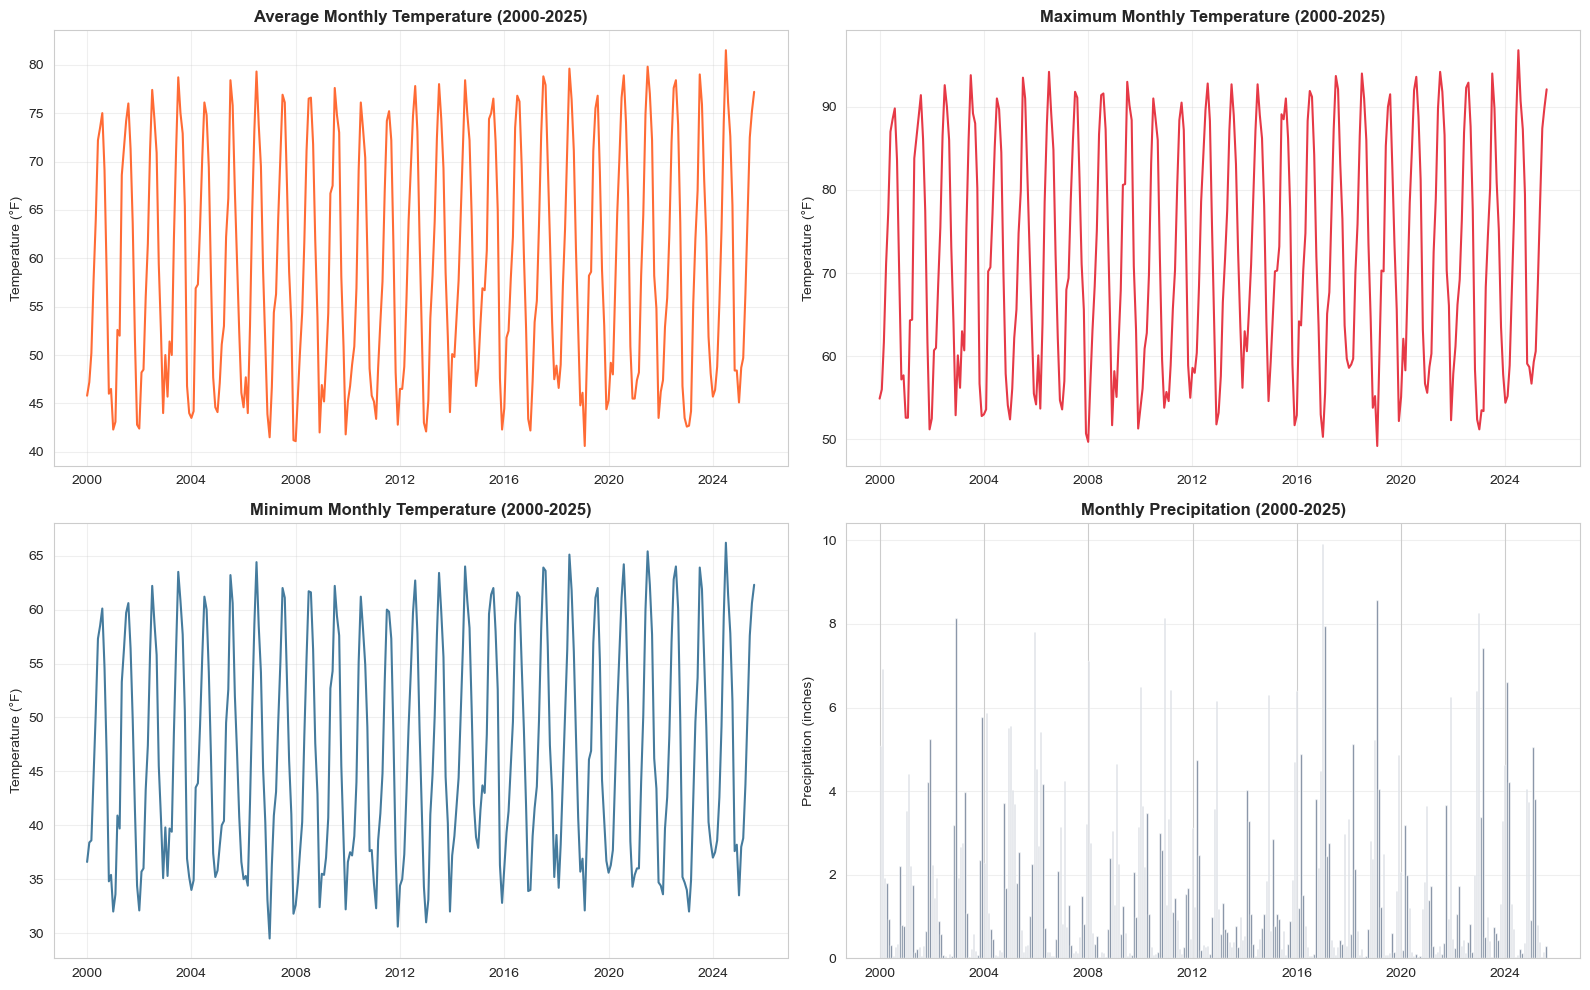


ADDITIONAL CLIMATE VISUALIZATIONS


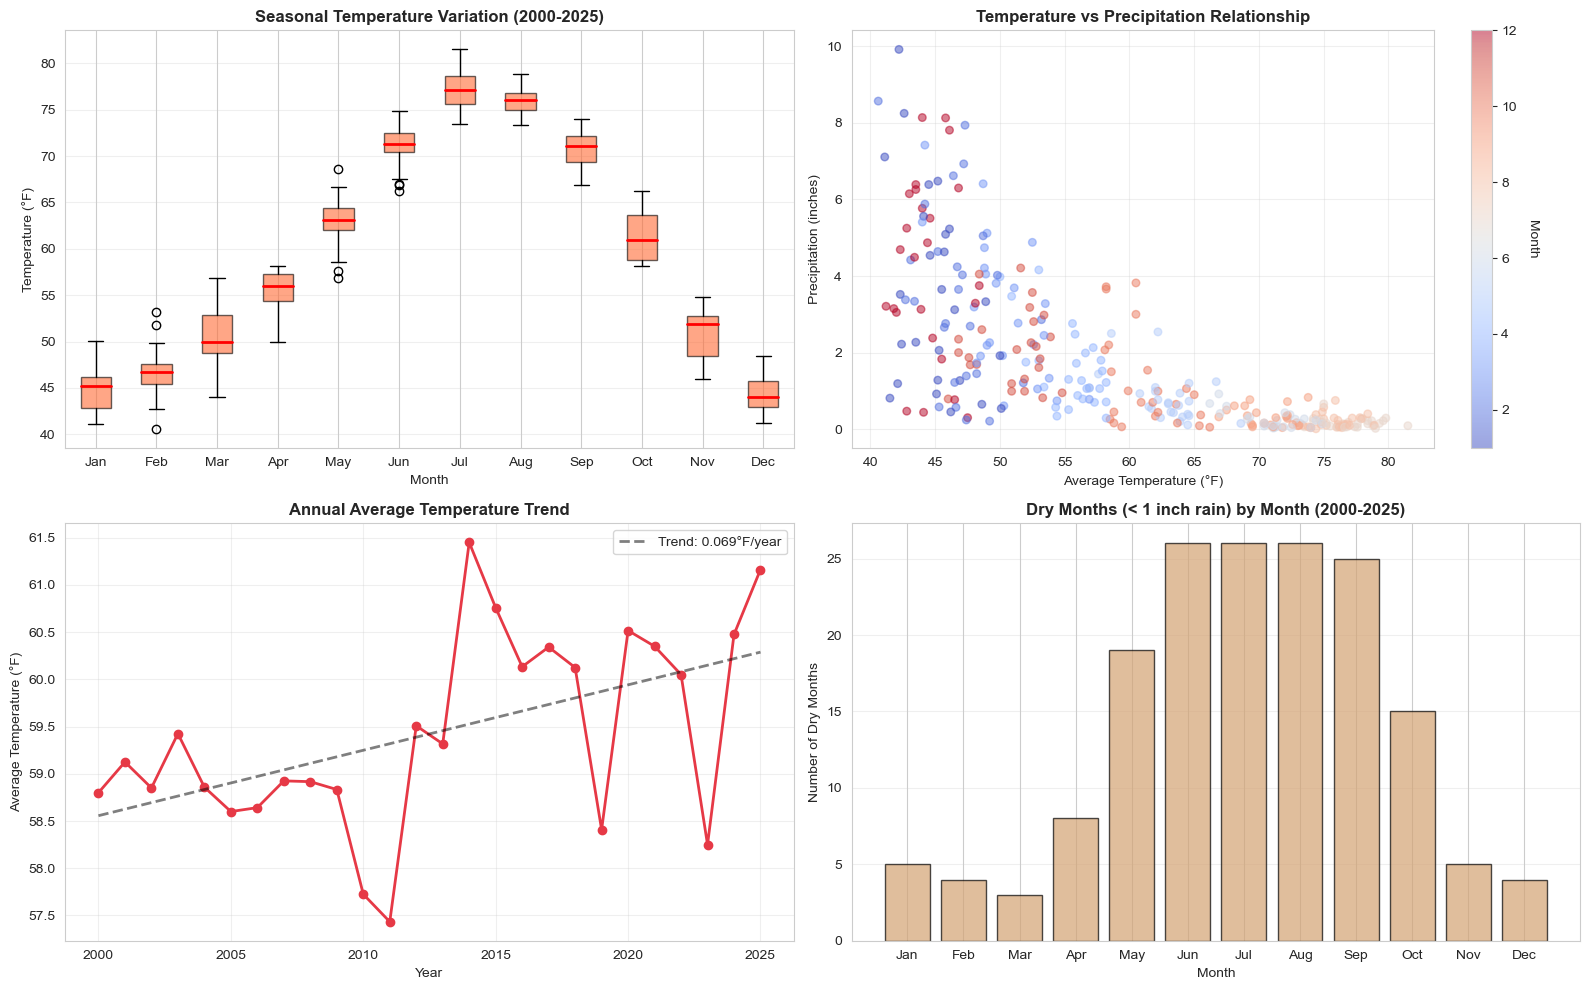

In [4]:
# Parse dates (YYYYMM format)
climate_df['Date'] = pd.to_datetime(climate_df['Date'], format='%Y%m')
climate_df = climate_df.sort_values('Date').reset_index(drop=True)

# Date range
print("=" * 80)
print("TEMPORAL COVERAGE")
print("=" * 80)
print(f"\nDate range: {climate_df['Date'].min().strftime('%B %Y')} to {climate_df['Date'].max().strftime('%B %Y')}")
print(f"Total months: {len(climate_df)}")
print(f"Years covered: {climate_df['Date'].dt.year.max() - climate_df['Date'].dt.year.min() + 1}")

# Check for missing months
expected_months = pd.date_range(start=climate_df['Date'].min(), end=climate_df['Date'].max(), freq='MS')
missing_months = set(expected_months) - set(climate_df['Date'])
print(f"\nMissing months: {len(missing_months)}")
if len(missing_months) > 0:
    print(f"Missing dates: {sorted(missing_months)}")

# Summary statistics
print("\n\n" + "=" * 80)
print("CLIMATE VARIABLE SUMMARY STATISTICS")
print("=" * 80)
print(climate_df[['Avg_Temp_F', 'Max_Temp_F', 'Min_Temp_F', 'Precip_Inches']].describe().round(2))

# Plot time series
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Average Temperature
axes[0, 0].plot(climate_df['Date'], climate_df['Avg_Temp_F'], color='#FF6B35', linewidth=1.5)
axes[0, 0].set_title('Average Monthly Temperature (2000-2025)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Temperature (°F)')
axes[0, 0].grid(True, alpha=0.3)

# Max Temperature
axes[0, 1].plot(climate_df['Date'], climate_df['Max_Temp_F'], color='#E63946', linewidth=1.5)
axes[0, 1].set_title('Maximum Monthly Temperature (2000-2025)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Temperature (°F)')
axes[0, 1].grid(True, alpha=0.3)

# Min Temperature
axes[1, 0].plot(climate_df['Date'], climate_df['Min_Temp_F'], color='#457B9D', linewidth=1.5)
axes[1, 0].set_title('Minimum Monthly Temperature (2000-2025)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Temperature (°F)')
axes[1, 0].grid(True, alpha=0.3)

# Precipitation
axes[1, 1].bar(climate_df['Date'], climate_df['Precip_Inches'], color='#1D3557', alpha=0.7, width=20)
axes[1, 1].set_title('Monthly Precipitation (2000-2025)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Precipitation (inches)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Additional visualizations
print("\n" + "=" * 80)
print("ADDITIONAL CLIMATE VISUALIZATIONS")
print("=" * 80)

# Create seasonal patterns
climate_df['Month'] = climate_df['Date'].dt.month
climate_df['Year'] = climate_df['Date'].dt.year

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Seasonal Temperature Pattern (Boxplot)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0, 0].boxplot([climate_df[climate_df['Month'] == i]['Avg_Temp_F'].values for i in range(1, 13)], 
                    labels=month_names, patch_artist=True,
                    boxprops=dict(facecolor='#FF6B35', alpha=0.6),
                    medianprops=dict(color='red', linewidth=2))
axes[0, 0].set_title('Seasonal Temperature Variation (2000-2025)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Temperature (°F)')
axes[0, 0].set_xlabel('Month')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Temperature vs Precipitation Scatter
axes[0, 1].scatter(climate_df['Avg_Temp_F'], climate_df['Precip_Inches'], 
                   alpha=0.5, s=30, c=climate_df['Month'], cmap='coolwarm')
axes[0, 1].set_title('Temperature vs Precipitation Relationship', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Average Temperature (°F)')
axes[0, 1].set_ylabel('Precipitation (inches)')
axes[0, 1].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[0, 1].collections[0], ax=axes[0, 1])
cbar.set_label('Month', rotation=270, labelpad=15)

# 3. Annual Average Temperature Trend
annual_avg_temp = climate_df.groupby('Year')['Avg_Temp_F'].mean()
axes[1, 0].plot(annual_avg_temp.index, annual_avg_temp.values, 
                marker='o', linewidth=2, markersize=6, color='#E63946')
axes[1, 0].set_title('Annual Average Temperature Trend', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Average Temperature (°F)')
axes[1, 0].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(annual_avg_temp.index, annual_avg_temp.values, 1)
p = np.poly1d(z)
axes[1, 0].plot(annual_avg_temp.index, p(annual_avg_temp.index), 
                "--", color='black', alpha=0.5, linewidth=2, label=f'Trend: {z[0]:.3f}°F/year')
axes[1, 0].legend()

# 4. Dry Season Analysis (Precipitation < 1 inch)
monthly_dry_count = climate_df[climate_df['Precip_Inches'] < 1.0].groupby('Month').size()
axes[1, 1].bar(range(1, 13), [monthly_dry_count.get(i, 0) for i in range(1, 13)], 
               color='#D4A373', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Dry Months (< 1 inch rain) by Month (2000-2025)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Number of Dry Months')
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].set_xticklabels(month_names)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## 4. January 2025 Weather Analysis 🔥


In [5]:
# Filter January 2025 climate (when Palisades & Eaton fires occurred)
jan_2025 = climate_df[climate_df['Date'] == '2025-01-01']

print("=" * 80)
print("JANUARY 2025 CLIMATE CONDITIONS (FIRE MONTH)")
print("=" * 80)

if len(jan_2025) > 0:
    print(f"\n🔥 January 2025 Weather Summary:")
    print(f"   Average Temperature: {jan_2025['Avg_Temp_F'].values[0]:.1f}°F")
    print(f"   Maximum Temperature: {jan_2025['Max_Temp_F'].values[0]:.1f}°F")
    print(f"   Minimum Temperature: {jan_2025['Min_Temp_F'].values[0]:.1f}°F")
    print(f"   Precipitation: {jan_2025['Precip_Inches'].values[0]:.2f} inches")
    
    # Compare to historical January average
    jan_historical = climate_df[climate_df['Date'].dt.month == 1]
    jan_avg_temp = jan_historical['Avg_Temp_F'].mean()
    jan_avg_precip = jan_historical['Precip_Inches'].mean()
    
    print(f"\n📊 Comparison to Historical January Average (2000-2024):")
    print(f"   Historical Avg Temp: {jan_avg_temp:.1f}°F")
    print(f"   2025 vs Historical: {jan_2025['Avg_Temp_F'].values[0] - jan_avg_temp:+.1f}°F")
    print(f"   Historical Avg Precip: {jan_avg_precip:.2f} inches")
    print(f"   2025 vs Historical: {jan_2025['Precip_Inches'].values[0] - jan_avg_precip:+.2f} inches")
    
    if jan_2025['Avg_Temp_F'].values[0] > jan_avg_temp:
        print(f"\n⚠️ January 2025 was WARMER than average!")
    if jan_2025['Precip_Inches'].values[0] < jan_avg_precip:
        print(f"⚠️ January 2025 was DRIER than average!")
else:
    print("\n⚠️ January 2025 data not yet available in dataset")

print("\n" + "=" * 80)


JANUARY 2025 CLIMATE CONDITIONS (FIRE MONTH)

🔥 January 2025 Weather Summary:
   Average Temperature: 45.1°F
   Maximum Temperature: 56.7°F
   Minimum Temperature: 33.5°F
   Precipitation: 0.92 inches

📊 Comparison to Historical January Average (2000-2024):
   Historical Avg Temp: 45.1°F
   2025 vs Historical: +0.0°F
   Historical Avg Precip: 3.55 inches
   2025 vs Historical: -2.63 inches

⚠️ January 2025 was WARMER than average!
⚠️ January 2025 was DRIER than average!



### Potential ML Features from Weather Data

From these basic weather measurements (TMAX, TMIN, PRCP), we can engineer many predictive features:

#### Temperature-Based Features:
1. **Daily Temperature Range** = TMAX - TMIN (large range indicates dry air)
2. **Average Daily Temperature** = (TMAX + TMIN) / 2
3. **7-day Rolling Average Temperature** (recent heat trend)
4. **30-day Rolling Average Temperature** (longer-term pattern)
5. **Temperature Anomaly** = Current temp - Historical average for that date
6. **Days Above Threshold** (e.g., days > 35°C in past week)
7. **Heat Wave Indicator** (consecutive days with high temps)

#### Precipitation-Based Features:
1. **Days Since Last Rain** (critical! dry fuels = fire risk)
2. **7-day Cumulative Precipitation** (recent moisture)
3. **30-day Cumulative Precipitation** (seasonal moisture)
4. **Precipitation Deficit** = Expected rain - Actual rain
5. **Dry Spell Length** (consecutive days with PRCP = 0)
6. **Wet vs. Dry Season Indicator**

#### Combined Features:
1. **Fire Weather Index** = f(temp, humidity, wind, precip) - standard metric
2. **Drying Index** = High temp + No rain
3. **Seasonal Context** (month, season, day of year)

#### Missing (To Add Later):
- ⏳ **Wind Speed** (Santa Ana winds - critical!)
- ⏳ **Wind Direction** (offshore vs. onshore)
- ⏳ **Relative Humidity** (low humidity = high fire risk)
- ⏳ **Wind Gusts** (fire spread accelerator)

These will be added from ERA5 or other sources in later phases.


## 5. Summary for ML Model


In [6]:
print("=" * 80)
print("CLIMATE DATA SUMMARY FOR ML MODEL")
print("=" * 80)

print(f"\n📊 Dataset Overview:")
print(f"   Total monthly records: {len(climate_df):,}")
print(f"   Date range: {climate_df['Date'].min().strftime('%B %Y')} to {climate_df['Date'].max().strftime('%B %Y')}")
print(f"   Years covered: {climate_df['Date'].dt.year.nunique()}")
print(f"   Temporal resolution: Monthly (statewide aggregates)")

print(f"\n🌡️ Climate Variables:")
print(f"   ✅ Average Temperature (°F)")
print(f"   ✅ Maximum Temperature (°F)")
print(f"   ✅ Minimum Temperature (°F)")
print(f"   ✅ Precipitation (inches)")

print(f"\n📍 Geographic Coverage:")
print(f"   Scope: Entire California state")
print(f"   Data aggregation: Statewide monthly averages from all NOAA stations")

print(f"\n🔥 January 2025 Fire Period:")
if len(jan_2025) > 0:
    print(f"   ✅ January 2025 data available")
    print(f"   ✅ Covers Palisades & Eaton fires period")
else:
    print(f"   ⏳ January 2025 data pending")

print(f"\n✅ Data Quality:")
print(f"   Missing values: {climate_df.isnull().sum().sum()} total")
print(f"   Data completeness: {(1 - climate_df.isnull().sum().sum() / (len(climate_df) * 4)) * 100:.1f}%")
print(f"   Source: NOAA Climate at a Glance (official, quality-controlled)")

print(f"\n📝 Next Steps:")
print(f"   1. Convert Fahrenheit to Celsius for consistency")
print(f"   2. Calculate derived features (temp range, seasonal patterns)")
print(f"   3. Merge with fire data by month/year")
print(f"   4. Add finer-resolution weather data (daily/hourly) if needed")

print("=" * 80)


CLIMATE DATA SUMMARY FOR ML MODEL

📊 Dataset Overview:
   Total monthly records: 308
   Date range: January 2000 to August 2025
   Years covered: 26
   Temporal resolution: Monthly (statewide aggregates)

🌡️ Climate Variables:
   ✅ Average Temperature (°F)
   ✅ Maximum Temperature (°F)
   ✅ Minimum Temperature (°F)
   ✅ Precipitation (inches)

📍 Geographic Coverage:
   Scope: Entire California state
   Data aggregation: Statewide monthly averages from all NOAA stations

🔥 January 2025 Fire Period:
   ✅ January 2025 data available
   ✅ Covers Palisades & Eaton fires period

✅ Data Quality:
   Missing values: 0 total
   Data completeness: 100.0%
   Source: NOAA Climate at a Glance (official, quality-controlled)

📝 Next Steps:
   1. Convert Fahrenheit to Celsius for consistency
   2. Calculate derived features (temp range, seasonal patterns)
   3. Merge with fire data by month/year
   4. Add finer-resolution weather data (daily/hourly) if needed
